## Seção 1: Importações e Leitura de Dados
- Nesta seção, importaremos as bibliotecas necessárias e leremos os dados.

In [97]:
# Importações
import numpy as np
import pandas as pd
import transformers
from transformers import BertModel
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
import torch
from torch import nn, optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import nltk # Para aumento de dados


import warnings
warnings.filterwarnings('ignore')

# Download de recursos NLTK (se necessário para o aumento de dados)
try:
    wordnet.ensure_loaded()
except LookupError:
    nltk.download('wordnet', quiet=True)
try:
    nltk.data.find('corpora/omw-1.4')
except nltk.downloader.DownloadError:
    nltk.download('omw-1.4', quiet=True) # WordNet multilingue, bom ter

In [98]:
# Leitura de Dados
try:
    df = pd.read_csv("../../data/data.csv") # Caminho original do notebook
except FileNotFoundError:
    print("Arquivo '../data/data.csv' não encontrado. Tentando 'data.csv' no diretório atual.")
    try:
        df = pd.read_csv("data.csv") # Tentativa alternativa
    except FileNotFoundError:
        print("ERRO: Arquivo de dados não encontrado. Verifique o caminho.")
        exit()

display(df.head())

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral
...,...,...
5837,RISING costs have forced packaging producer Hu...,negative
5838,Nordic Walking was first used as a summer trai...,neutral
5839,"According shipping company Viking Line , the E...",neutral
5840,"In the building and home improvement trade , s...",neutral


## Seção 1.5: Análise Exploratória de Dados
- Nesta seção, analisaremos os dados para obter uma melhor compreensão deles.
- Também verificaremos o desequilíbrio de dados.

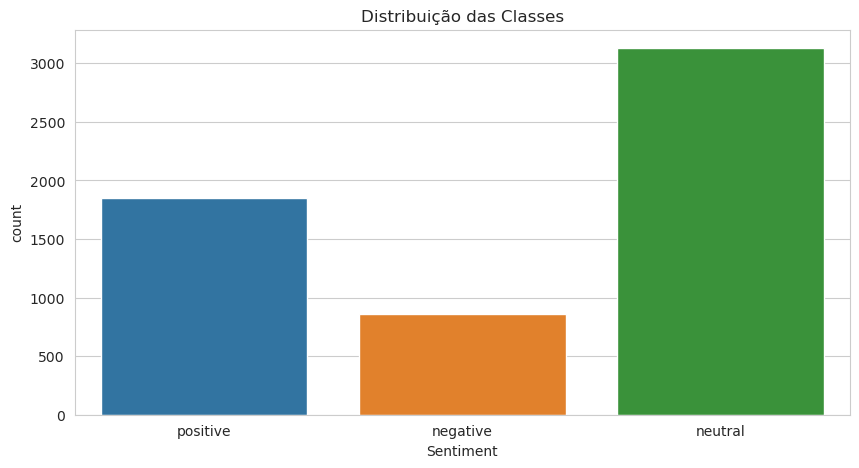

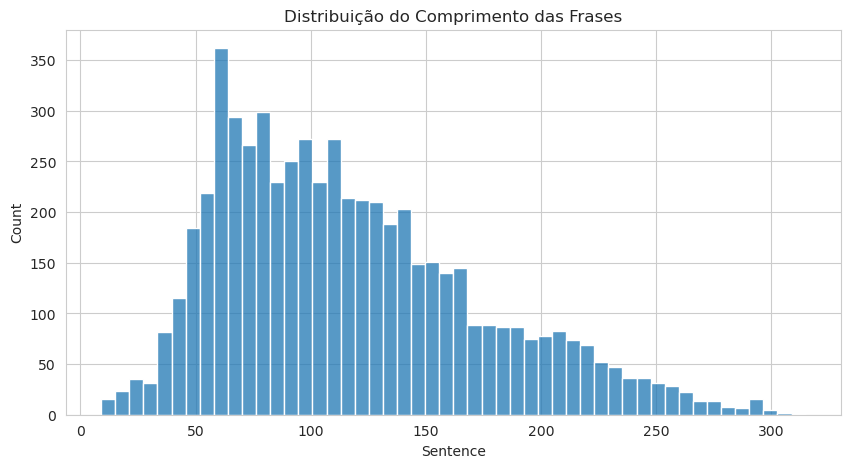

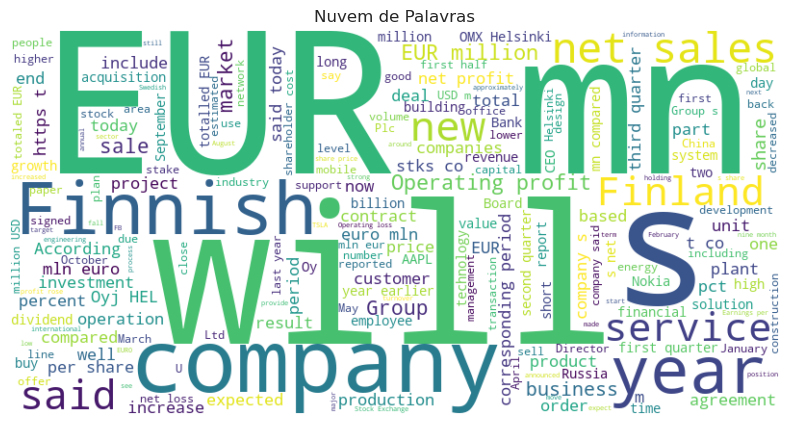

In [99]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Gráfico de barras para visualizar a distribuição das classes
plt.figure(figsize=(10, 5))
sns.countplot(x='Sentiment', data=df)
plt.title('Distribuição das Classes')
plt.show()

# Histograma para visualizar o comprimento das frases
plt.figure(figsize=(10, 5))
sns.histplot(df['Sentence'].str.len(), bins=50)
plt.title('Distribuição do Comprimento das Frases')
plt.show()

# Nuvem de palavras para visualizar as palavras mais comuns
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df['Sentence']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nuvem de Palavras')
plt.show()

## Seção 2: Pré-processamento e Tokenização
- Aqui usaremos o modelo BERT pré-treinado para tokenizar nossos dados, além de aumentar os dados para a classe menos dominante.

In [100]:
# Remover linhas com valores nulos
df = df.dropna()

# Atualizar rótulos
encoder = LabelEncoder()
labels = encoder.fit_transform(df.Sentiment)

# Dividir os dados em treinamento e teste antes do aumento de dados
X, X_test_final, y, y_test_final = train_test_split(df.Sentence.values, labels, test_size=0.2, stratify=df.Sentiment.values)

print(f"X: {len(X)}\t y: {len(y)}")
print(f"X_test_final: {len(X_test_final)}\t y_test_final: {len(y_test_final)}")

# Contagem de classes após a divisão para treino e teste
print(pd.Series(y).value_counts())
print(pd.Series(y_test_final).value_counts())

X: 4673	 y: 4673
X_test_final: 1169	 y_test_final: 1169
1    2504
2    1481
0     688
dtype: int64
1    626
2    371
0    172
dtype: int64


## Seção 2.5: Aumento de Dados
- Nesta seção, aumentaremos os dados para a classe menos dominante usando sinônimos. Isso é feito para evitar o desequilíbrio de dados.
- Para aumentar os dados, usaremos a biblioteca NLTK para encontrar sinônimos de palavras e substituir palavras aleatórias por seus sinônimos, com uma probabilidade de 15%.

In [101]:
from nltk.corpus import wordnet
import random

# Função para aumentar os dados substituindo palavras por seus sinônimos
def aumentar_frase(frase):
    palavras = frase.split(' ')
    for i in range(len(palavras)):
        if random.uniform(0, 1) < 0.15:  # 15% de chance de substituir uma palavra
            sinonimos = wordnet.synsets(palavras[i])
            if sinonimos:
                palavras[i] = sinonimos[0].lemmas()[0].name()  # Substituir pelo primeiro sinônimo
    return ' '.join(palavras)

# Identificar a classe menos dominante
contagem_classes = pd.Series(y).value_counts()
classe_menos_dominante = contagem_classes.idxmin()

# Aumentar os dados para a classe menos dominante
df_train = pd.DataFrame({'Sentiment': X, 'labels': y})
df_menos_dominante = df_train[df_train['labels'] == classe_menos_dominante]
df_aumentado = df_menos_dominante['Sentiment'].apply(aumentar_frase)

# Criar novas instâncias e adicionar aos dados de treinamento
novas_instancias = df_menos_dominante.copy()
novas_instancias['Sentiment'] = df_aumentado
df_train = pd.concat([df_train, novas_instancias])

# Atualizar X e y
X_train = df_train.Sentiment.values
y_train = df_train.labels.values


In [102]:
# Tokenização
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
# X_train, X_test_final, y_train, y_test_final = train_test_split(df.Sentence.values, labels, test_size=0.1,
                                                                # stratify=df.Sentiment.values)

## Seção 2.7: Análise após Aumento de Dados e Tokenização

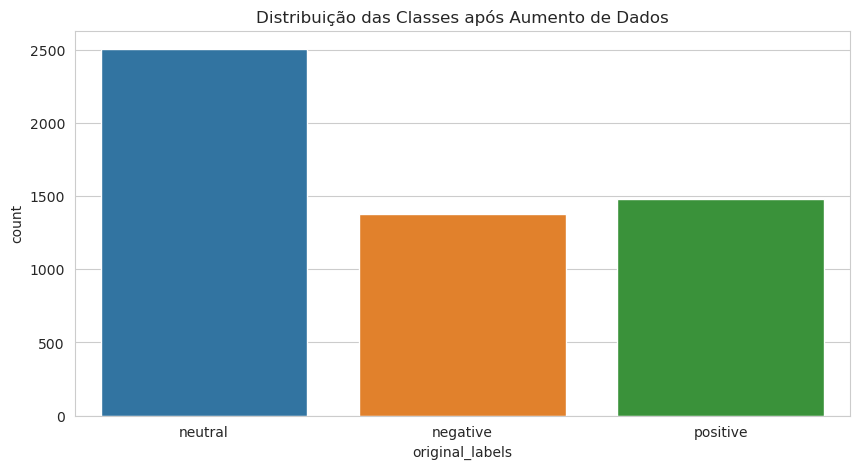

neutral     2504
positive    1481
negative    1376
Name: original_labels, dtype: int64


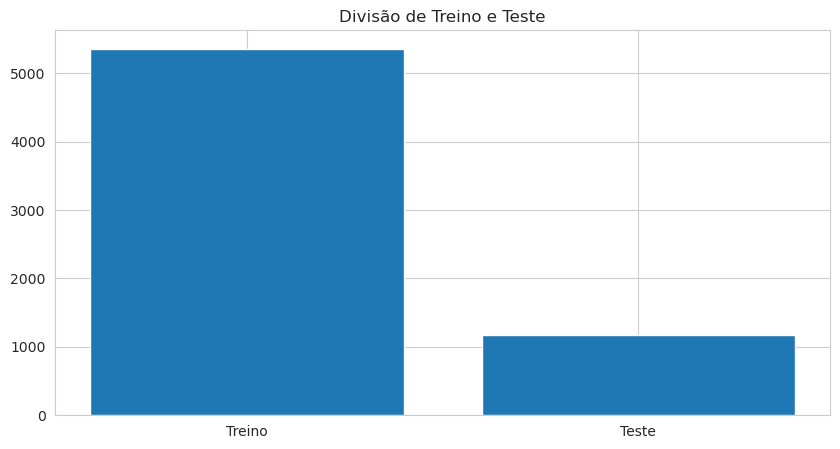

In [103]:
# Adicionar uma nova coluna com os nomes originais das classes
df_train['original_labels'] = encoder.inverse_transform(df_train['labels'])

# Gráfico de barras para visualizar a distribuição das classes após o aumento de dados. Mostrando os valores no topo das barras
plt.figure(figsize=(10, 5))
sns.countplot(x='original_labels', data=df_train)
plt.title('Distribuição das Classes após Aumento de Dados')
plt.show()

# Imprimir o número de instâncias para cada classe após o aumento de dados
print(df_train['original_labels'].value_counts())

# Gráfico de barras para visualizar a divisão de treino e teste
plt.figure(figsize=(10, 5))
plt.bar(['Treino', 'Teste'], [len(X_train), len(X_test_final)])
plt.title('Divisão de Treino e Teste')
plt.show()

## Seção 3: Classe do Conjunto de Dados

In [104]:
# Classe do Conjunto de Dados
class Datagen(Dataset):
    def __init__(self, sentence, target, tokenizer, max_len):
        self.sentence = sentence
        self.target = target
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.sentence)

    def __getitem__(self, idx):
        sentence = self.sentence[idx]
        bert_encoding = tokenizer.encode_plus(
            sentence,
            max_length=self.max_len,
            add_special_tokens=True,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt'
        )
        return {
            "input_ids": torch.squeeze(bert_encoding["input_ids"]),
            "attention_mask": torch.squeeze(bert_encoding["attention_mask"]),
            "target": torch.tensor(self.target[idx], dtype=torch.long)
        }


## Seção 4: Parâmetros do Modelo

In [105]:
class SentimentModel(nn.Module):
    def __init__(self, n_class):
        super(SentimentModel, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.drop = nn.Dropout(0.5)
        self.out = nn.Linear(self.bert.config.hidden_size, n_class)

    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(input_ids, attention_mask, return_dict=False)
        output = self.drop(pooled_output)
        return self.out(output)

model = SentimentModel(n_class=3)
model = model.to(torch.device('cuda'))
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(optimizer, 'min',verbose=True)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Seção 5: Funções Auxiliares

In [106]:
def check_acc(preds, labels):
    correct = 0
    for pred, label in zip(preds, labels):
        if pred == label:
            correct += 1
    return correct/len(preds)

def accuracy(dataloader, model):
    model.eval()
    batch_acc = 0
    for inputs in dataloader:
        to_cuda = lambda x: x.to(torch.device('cuda'), non_blocking=True).long()
        input_ids, attention_mask, target = list(map(to_cuda, inputs.values()))

        outputs = model(input_ids, attention_mask)
        prediction = outputs.argmax(dim=1)
        acc = check_acc(prediction, target)
        batch_acc += acc
    return batch_acc/len(dataloader)


## Seção 6: Treinamento com Validação Cruzada

In [ ]:
num_epochs = 10
num_splits = 5
skf = StratifiedKFold(n_splits=num_splits, shuffle=True)
cv_fold_acc = []
cv_epoch_acc = []
best_cv_acc = 0
# Listas para armazenar perda de treinamento e validação
train_losses = []
cv_losses = []

for fold, (train_index, test_index) in enumerate(skf.split(X_train, y_train)):

    with torch.no_grad():
        torch.cuda.empty_cache()
    # Crie uma nova instância do modelo para cada dobra
    model = SentimentModel(n_class=3)  # Substitua YourModel pela classe ou função real para criar seu modelo
    model.to(torch.device('cuda'))
    
    print(f"\n\n\nFold {fold + 1}/{skf.get_n_splits()}")

    X_train_fold, X_temp = X_train[train_index], X_train[test_index]
    y_train_fold, y_temp = y_train[train_index], y_train[test_index]


    # Dividir ainda mais o conjunto de teste em cv e teste
    X_cv, X_test, y_cv, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp)

    train_data = Datagen(X_train, y_train, tokenizer, 50)
    cv_data = Datagen(X_cv, y_cv, tokenizer, 50)
    test_data = Datagen(X_test, y_test, tokenizer, 50)

    train_dataloader = DataLoader(train_data, batch_size=16, num_workers=2)
    cv_dataloader = DataLoader(cv_data, batch_size=15, num_workers=2)
    test_dataloader = DataLoader(test_data, batch_size=15, num_workers=2)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs * len(train_dataloader))

    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
    criterion = nn.CrossEntropyLoss()

    # Listas para armazenar perda de treinamento e validação para cada dobra
    all_train_losses = []
    all_cv_losses = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for steps, inputs in enumerate(train_dataloader):
            to_cuda = lambda x: x.to(torch.device('cuda'), non_blocking=True).long()
            input_ids, attention_mask, target = list(map(to_cuda, inputs.values()))
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        average_loss = total_loss / len(train_dataloader)
        train_losses.append(average_loss)  # Salve a perda de treinamento

        train_acc = accuracy(train_dataloader, model)
        cv_acc = accuracy(cv_dataloader, model)
        cv_epoch_acc.append(cv_acc)

        print(f"Fold {fold + 1}/{skf.get_n_splits()}\t Época: {epoch}/{num_epochs}\t Precisão de treinamento: {train_acc}\t Precisão de CV: {cv_acc}")
                
        scheduler.step()

    cv_fold_acc.append(cv_epoch_acc[-1])
    cv_loss = criterion(outputs, target).item()  # Calcule a perda de validação
    cv_losses.append(cv_loss)  # Salve a perda de validação

    all_train_losses.append(train_losses)
    all_cv_losses.append(cv_losses)


In [ ]:

print(f"Precisão média de CV: {np.mean(cv_fold_acc)}")
# Melhor precisão de CV:
print(f"Melhor precisão de CV: {np.max(cv_fold_acc)}")

# Pior precisão de CV:
print(f"Pior precisão de CV: {np.min(cv_fold_acc)}")


## Seção 6.5: Gráfico de Perda de Treinamento e Acuracia de Validação

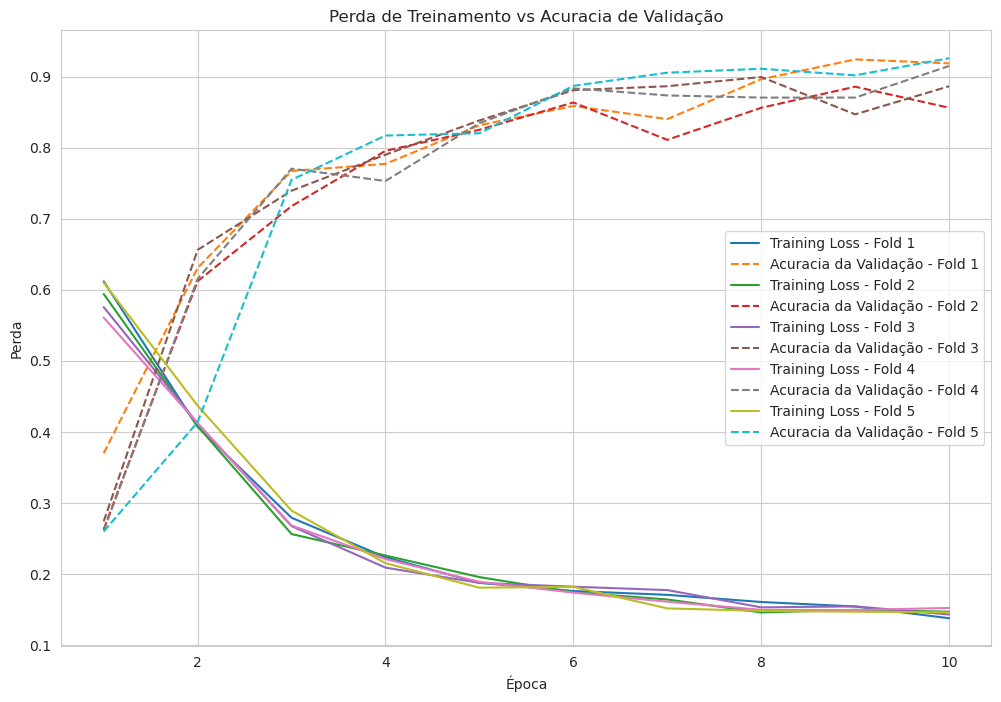

In [109]:
import matplotlib.pyplot as plt


# Crie uma nova figura para o gráfico
plt.figure(figsize=(12, 8))

# Plotar perda de treinamento e validação para cada dobra, cada dobra tem n_epochs elementos. Logo, se tenho 2 folds e 10 epochs, o primeior grafico os elementos de 0 a 9, e o segundo de 10 a 19

for fold in range(num_splits):
    # Get the training and validation loss for each fold
    start_index = fold * num_epochs
    end_index = start_index + num_epochs-1
    train_loss = all_train_losses[0][start_index:end_index+1]
    cv_loss = cv_epoch_acc[start_index:end_index+1]
    # Create a list of epochs for each fold
    epochs = list(range(1, len(train_loss) + 1))

    # Plot the training and validation loss for each fold
    plt.plot(epochs, train_loss, label=f'Training Loss - Fold {fold + 1}')
    plt.plot(epochs, cv_loss, label=f'Acuracia da Validação - Fold {fold + 1}', linestyle='--')


# Adicione rótulos aos eixos e um título
plt.xlabel('Época')
plt.ylabel('Perda')
plt.title('Perda de Treinamento vs Acuracia de Validação')

# Adicione uma legenda
plt.legend()

# Mostre o gráfico
plt.show()

## Seção 7: Testando o Modelo

Precisão de teste: 0.7527472527472526
              precision    recall  f1-score   support

           0       0.42      0.80      0.56       172
           1       0.88      0.73      0.80       626
           2       0.87      0.77      0.82       371

    accuracy                           0.75      1169
   macro avg       0.73      0.77      0.72      1169
weighted avg       0.81      0.75      0.77      1169


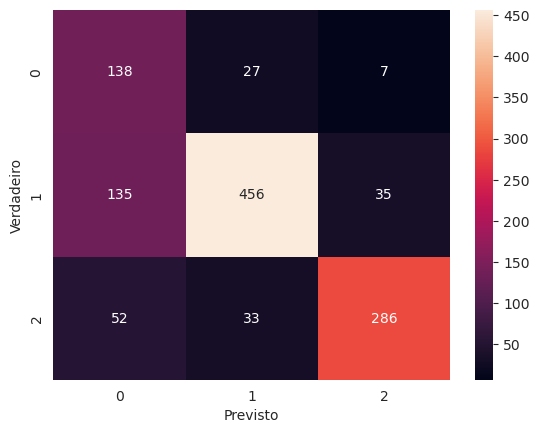

In [110]:
# Testando
model.eval()

# Datagen e Dataloader para teste_final
test_final_data = Datagen(X_test_final, y_test_final, tokenizer, 50)
test_final_dataloader = DataLoader(test_final_data, batch_size=15, num_workers=2)



test_acc = accuracy(test_final_dataloader, model)
print(f"Precisão de teste: {test_acc}")

# Métricas para classificação, use isso para obter precisão, recall, f2 de sklearn.metrics import classification_report, usando cpu.
from sklearn.metrics import classification_report

y_pred = []
y_true = []
for inputs in test_final_dataloader:
    to_cuda = lambda x: x.to(torch.device('cuda'), non_blocking=True).long()
    input_ids, attention_mask, target = list(map(to_cuda, inputs.values()))

    outputs = model(input_ids, attention_mask)
    prediction = outputs.argmax(dim=1)
    y_pred.extend(prediction.cpu().numpy())
    y_true.extend(target.cpu().numpy())

print(classification_report(y_true, y_pred))
# Matriz de Confusão
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Previsto')
plt.ylabel('Verdadeiro')
plt.show()

## Seção 8: Salvando o Modelo

In [78]:
# Salvando o modelo
torch.save(model.state_dict(), "model_otp_balanceado.pt")

In [21]:
del model
import gc
gc.collect()
torch.cuda.empty_cache() # Coisa do PyTorch